# Análise Exploratória de Dados
## Importando bibliotecas

In [1]:
from src.data import prepare
from src.data import process
from src.data import visualize

import pandas as pd
import numpy as np
import re
import string
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud
from PIL import Image

plt.style.use('seaborn-notebook')
%matplotlib inline

## Carregando os dados

In [2]:
true_path = "../data/raw/full_texts/true/"
fake_path = "../data/raw/full_texts/fake/"
output_path = "../data/interim/news.csv"

prepare.make_text_dataframe(true_path, fake_path, output_path)

## Importando dados pré-processados

In [3]:
news_df = pd.read_csv(output_path)
news_df.sample(10)

,text,label
6646,Temer resolve o problema de Luislinda: liberd...,fake
5843,"Em Brasília, políticos fogem de Lula como o d...",fake
2157,"A Melhor Escolha, de Richard Linklater, está e...",true
2422,O renascimento na arena global. Depois de anos...,true
393,Queridos leitores Passei quatro dias no chama...,true
5339,"Magno Malta para Lindinho: ""Vocês querem taxar...",fake
4215,"Não é calúnia, é fato! Juíza absolve apresenta...",fake
1257,Moro nega pedido de defesa de Lula e Palocci e...,true
2828,Militares dizem que Lula não influenciou Dilma...,true
1880,Santana diz que cancelou passagem para o Brasi...,true


## Pré-Processamento Básico

### Removendo pontuação

In [4]:
punctuation = list(string.punctuation) # Obtendo os caracteres especiais como lista
del(punctuation[12]) # Excluindo da remoção o caractere especial "-"
punctuation = "".join(punctuation) # Transformando novamente em string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [5]:
news_df['text'] = news_df['text'].apply(lambda c: re.sub('[%s]' % re.escape(punctuation), '', c))
news_df.sample(10)

,text,label
427,Após reunião com secretário de Estado dos EUA ...,true
6893,Lula tropeça nas palavras Serei candidato com ...,fake
2768,Justiça de Mogi bloqueia bens de vereador e em...,true
4833,Pilantragem petista Vídeo flagra candidata a v...,fake
65,Crise econômica no Brasil não existe diz Temer...,true
805,Segunda-feira 2 de outubro de 2017 Boa noite A...,true
2426,Mulher induz criança a roubar aparelho celular...,true
395,Satélite mostra atividade em base de lançament...,true
2257,Juiz federal do DF manda suspender nomeação do...,true
5087,O dia em que o muso do FORA TEMER expulsou uma...,fake


### Passando as palavras para minúsculo

In [6]:
news_df['text'] = news_df['text'].apply(lambda x: x.lower())
news_df.sample(10)

,text,label
3707,6 fatos que comprovam que a viagem de temer à ...,fake
6188,pátria educadora mais de 53 mil candidatos tir...,fake
3449,como a visão utópica do vale do silício pode c...,true
2064,duque diz estar disposto a devolver 20 milhões...,true
2433,feriado de corpus christi de 15 a 18 de junho ...,true
6813,joão doria bate boca com fhc tucanos em guerra...,fake
1372,renan acusa temer de negociar com janot para s...,true
4985,gleisi se irrita quando janaína cita deus gle...,fake
4285,jornalista usa twitter e diz que esposa de lul...,fake
3590,dançarina morta após show foi atingida por veí...,true


## Analisando os dados obtidos

### Quantidade de dados

In [7]:
news_df['label'].value_counts()

true    3600
fake    3600
Name: label, dtype: int64

*O conjunto de dados do corpus se encontra balanceado. 
Pois há um número igual de amostras (textos) em ambas as classes: verdadeiros (true) e falsos (fake).*

### Comprimento

#### De todo o texto

- Qual o comprimento dos textos obtidos?
- O comprimento dos textos difere entre falsos e verdadeiros?

In [8]:
news_df['text_length'] = news_df['text'].str.len()

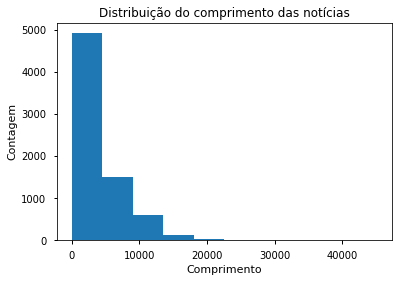

In [9]:
plt.hist(news_df.text_length)
plt.xlabel('Comprimento')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.show()

In [10]:
news_df.text_length.describe()

count     7200.000000
mean      3797.509444
std       3963.118688
min         44.000000
25%        919.000000
50%       2128.000000
75%       5465.000000
max      45033.000000
Name: text_length, dtype: float64

*A maioria dos textos têm um comprimento pequeno (menos de 5 mil palavras), a partir disso decidimos averiguar a distribuição do comprimento entre notícias verdadeiras e falsas.*

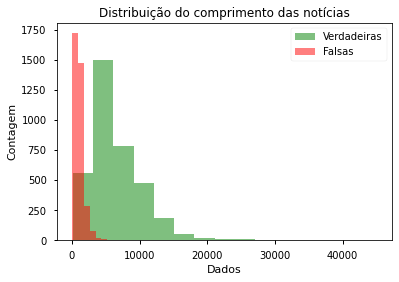

In [11]:
bins = 15
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_length,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_length,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.legend(loc='upper right')

plt.show()

*As notícias têm entre 46 e cerca de 46000 palavras, se distribuindo de maneira desigual de acordo com sua categoria. O comprimento das notícias verdadeiras tem tamanhos mais variados e mediana superior às notícias falsas, cujo comprimento se concentra numa faixa reduzida.* 

*Dentro desse conjunto de dados, notícias falsas tendem a ser mais curtas.*

#### Das palavras

- Há diferença no tamanho médio das palavras entre as diferentes categorias de notícias?

In [12]:
news_df['mean_word_len'] = (
    news_df['text']
    .str
    .split()
    .apply(lambda text : [len(word) for word in text])
    .map(lambda word: np.mean(word))
)

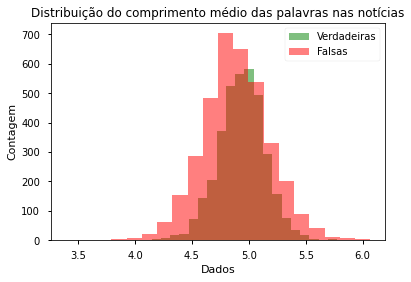

In [13]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento médio das palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

*Podemos observar um ligeiro deslocamento entre a média dos dados das notícias falsas e verdadeiras, apesar curva da distribuição se apresentar de maneira similar. Esta semelhança pode advir do fato de notícias de ambas categorias apresentarem a mesma temática e por tanto se utilizarem dos mesmos vocábulos.*

### Número de palavras

In [14]:
news_df['text_size'] = (
    news_df['text']
    .str
    .split()
    .str
    .len()
)

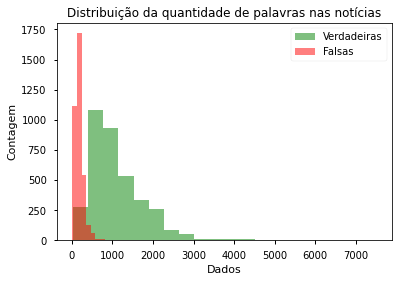

In [15]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_size,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_size,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição da quantidade de palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

### Nuvens de palavras
- As palavras mais usadas nas notícias abordadas estão dentro dos mesmos campos semânticos?

In [16]:
nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/samya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


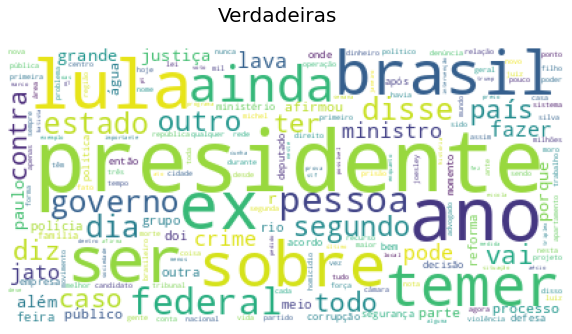

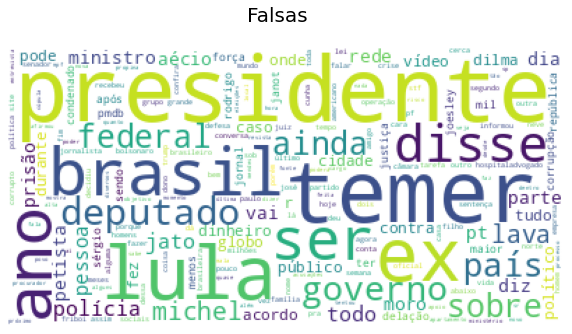

In [17]:
visualize.show_wordcloud(news_df[news_df.label == 'true'].text[0:100], 
               stop, title = 'Verdadeiras')

visualize.show_wordcloud(news_df[news_df.label == 'fake'].text[0:100], 
               stop, title = 'Falsas')

plt.show()

*Observamos que alguns vocábulos são bastante frequentes tanto em notícias falsas e verdadeiras, eles centram ao redor de cargos políticos("presidente"), figuras políticas("temer", "lula"), país("Brasil"). Alguns ainda são mais frequentes em notícias falsas, como as figuras políticas*

### N-gramas
- Em que contextos as palavras são usadas?

In [ ]:
news_df['text'] = news_df['text'].apply(lambda c: process.remove_day(c))
news_df['text']
news_df.sample(10)

*Retiramos os dias da semana que estavam contaminando a visualização do bigrama.*

In [ ]:
true_corpus = process.create_corpus(news_df[news_df.label == 'true'].text)
fake_corpus = process.create_corpus(news_df[news_df.label == 'fake'].text)

true_n_gram = process.get_top_ngram(corpus = true_corpus, n=2, top=10, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=2, top=10, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

*Podemos observar que em ambas as categorias, se faz referência a "ex presidente" e a ocupantes anteriores de cargos ("ex ministro", "ex deputado", "ex governador"), havendo também em ambas as notícias a menção de "norte-coreano" e a família jong-un.*

In [ ]:
true_n_gram = process.get_top_ngram(corpus = true_corpus, n=3, top=5, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=3, top=5, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

A eliminação da pontuação foi suficiente para reduzir a frequência de trigramas contendo datas e endereços eletrônicos.

*Apagar depois, texto escrito pré-remoção da pontuação*

Com a visualização em trigramas fica mais fácil observar a contaminação nos textos. Observamos 

- datas, ex: "28 07 2016", "16 02 2017"
- endereços eletrônicos 
    - aparentemente relacionados, ex: "www institutolula org"
    - aparentemente não relacionados, ex: "www letras mus"

Uma eliminação de números e endereços eletrônicos (palavras com www, https, etc) poderá melhorar a qualidade dos dados.

Observamos também nas notícias falsas vocabulários informais('mi-mi-mi', 'brasil-sil-sil'), não ocorrendo nas notícias verdadeiras.